In [2]:
from itertools import chain, combinations
from typing import Iterable, List, Optional, Tuple, Union

import numpy as np
from scipy import sparse

import networkx as nx

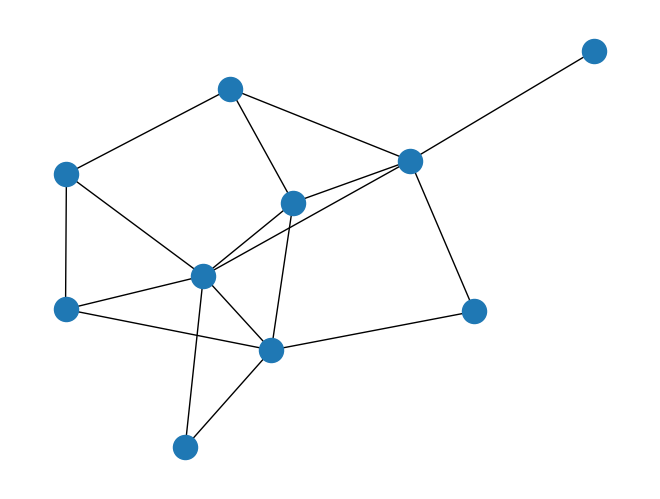

In [21]:
n = 10
p = 0.3
G = nx.erdos_renyi_graph(n, p, seed=5, directed=False)
nx.draw(G)

In [4]:
existing_edges = []
for edge in G.edges():
    existing_edges.append(list(edge))

In [5]:
nx.complement(G).edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (1, 2), (1, 3), (1, 5), (1, 7), (1, 8), (2, 5), (2, 6), (2, 8), (3, 4), (3, 7), (4, 5), (4, 6), (4, 8), (4, 9), (5, 6), (5, 8), (5, 9), (6, 7), (6, 8), (7, 8)])

In [31]:
complement_edges = []
for comb in combinations(np.arange(n).tolist(), 2):
    if list(comb) in existing_edges:
        print(comb)
    else:
        complement_edges.append(list(comb))

(0, 7)
(1, 4)
(1, 6)
(1, 9)
(2, 3)
(2, 4)
(2, 7)
(2, 9)
(3, 5)
(3, 6)
(3, 8)
(3, 9)
(4, 7)
(5, 7)
(6, 9)
(7, 9)
(8, 9)


In [484]:
complement_edges

[[0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 8],
 [0, 9],
 [1, 2],
 [1, 3],
 [1, 5],
 [1, 7],
 [1, 8],
 [2, 5],
 [2, 6],
 [2, 8],
 [3, 4],
 [3, 7],
 [4, 5],
 [4, 6],
 [4, 8],
 [4, 9],
 [5, 6],
 [5, 8],
 [5, 9],
 [6, 7],
 [6, 8],
 [7, 8]]

In [9]:
def LG(edges, x):
    results = 0
    for edge in edges:
        results += x[edge].prod()
    return results

def calc_obj_function(edges, x, tau):
    k = len(edges[0])
    LG_x = LG(edges, x)
    return LG_x + tau * (x ** k).sum()

def calc_gradient(edges, x, n, tau):
    gradient = np.zeros(n)
    for edge in edges:
        x_edge = x[edge]
        product = x_edge.prod()
        for i in range(len(edge)):
            node = edge[i]
            node_value = x_edge[i]
            if node_value != 0:
                gradient[node] += product / node_value
            else:
                remaining_nodes = edge[:i] + edge[i+1:]
                remaining_product = x[remaining_nodes].prod()
                gradient[node] += remaining_product
    k = len(edges[0])
    gradient += tau * k * (x ** (k - 1))
    return gradient

In [493]:
def calc_obj_function2(edges, x, tau):
    k = len(edges[0])
    LG = x[edges].prod(axis=1).sum()
    return LG + tau * (x ** k).sum()

In [529]:
def calc_gradient2(edges, x, n, tau):
    hg_matrix = x[edges]
    hg_indices = np.array(edges)
    k = hg_matrix.shape[1]
    e = hg_matrix.shape[0]
    remaining_products = np.zeros(hg_matrix.shape)
    for i in range(k):
        new_matrix = hg_matrix.copy()
        new_matrix[:,i] = np.ones(e)
        remaining_products[:,i] = new_matrix.prod(axis=1)
    grad = np.zeros(n)
    for i in range(n):
        grad[i] = remaining_products[hg_indices == i].sum()
    return grad + tau * k * (x ** (k - 1))

In [524]:
hg_indices = np.array(complement_edges)
remaining_products[hg_indices == 0]

array([0.11614624, 0.09788834, 0.08848864, 0.06880123, 0.10489274,
       0.07106385, 0.15649814, 0.06227063])

In [523]:
hg_matrix = x[complement_edges]
hg_indices = np.array(complement_edges)
k = hg_matrix.shape[1]
e = hg_matrix.shape[0]
n = 10
remaining_products = np.zeros(hg_matrix.shape)
for i in range(k):
    new_matrix = hg_matrix.copy()
    new_matrix[:,i] = np.ones(e)
    remaining_products[:,i] = new_matrix.prod(axis=1)
grad = np.zeros(n)
for i in range(n):
    grad[i] = remaining_products[hg_indices == i].sum()
grad

array([0.76604979, 0.68171806, 0.53772788, 0.41889768, 0.5723409 ,
       0.66179533, 0.66203065, 0.43219686, 0.6927426 , 0.26282089])

In [492]:
np.random.seed(0)
x = np.random.rand(n)
x = x / x.sum()

0.2901862318886209

In [527]:
calc_gradient(complement_edges, x, n, 0.55)

array([0.8640894 , 0.80947892, 0.64540505, 0.51623518, 0.64802226,
       0.77717735, 0.74020089, 0.59150248, 0.86489055, 0.33131858])

In [530]:
calc_gradient2(complement_edges, x, n, 0.55)

array([0.8640894 , 0.80947892, 0.64540505, 0.51623518, 0.64802226,
       0.77717735, 0.74020089, 0.59150248, 0.86489055, 0.33131858])

In [537]:
for _ in range(10**6):
    calc_gradient(complement_edges, x, 10, 0.5)

In [536]:
for _ in range(10**6):
    calc_gradient2(complement_edges, x, 10, 0.5)

In [91]:
x1 = np.zeros(n)
x1[0] = 1
grad = calc_gradient(complement_edges, x1, n, 0.55)
grad_argmin = grad.argmin()
s = np.zeros(n)
s[grad_argmin] = 1
d = s - x1
d

array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [74]:
x1, x1 + d

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [124]:
gamma = 0.5
calc_obj_function(complement_edges, x1, 0.55), calc_obj_function(complement_edges, x1 + gamma * d, 0.55)

(0.55, 0.275)

In [127]:
a = np.array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1])
a = a / a.sum()
calc_obj_function(complement_edges, a, 0.51), calc_obj_function(complement_edges, x_k, 0.51)

(0.16999999999999998, 0.16949559775053893)

In [318]:
a = np.array([0.2  , 0.   , 0.075, 0.   , 0.125, 0.2  , 0.2  , 0.   , 0.2  , 0.   ])
calc_obj_function(existing_edges, a, 0.5)

0.1

In [319]:
a = np.array([0.2   , 0.2001, 0.1999, 0.    , 0.    , 0.2   , 0.    , 0.    , 0.2   , 0.    ])
calc_obj_function(existing_edges, a, 0.5)

0.10000001000000001

In [19]:
(x @ nx.adjacency_matrix(nx.complement(G)) @ x) / 2

0.24584104703871493

In [20]:
nx.adjacency_matrix(nx.complement(G)) @ x

array([0.70589106, 0.744212  , 0.36135886, 0.41849377, 0.54982639,
       0.61401219, 0.74004407, 0.26910513, 0.72079111, 0.33073973])

In [67]:
0.8 ** 2

0.6400000000000001

In [469]:
def frank_wolfe(edges, n, tau, max_iter = 10000, tol=1e-4, line_search='fixed_rule', seed=None):
    rng = np.random.default_rng(seed)
    x_k = rng.random(n)
    x_k = x_k / x_k.sum()
    #x_k = np.zeros(n)
    #x_k[7] = 1
    gamma = 1
    for k in range(max_iter):
        print(f'---------------------------------Iteration {k}-----------------------------------')
        s = np.zeros(n)
        grad = calc_gradient(edges, x_k, n, tau)
        grad_argmin = grad.argmin()
        # print(grad_argmin)
        s[grad_argmin] = 1
        d = s - x_k
        duality_gap = grad @ d

        if line_search == 'fixed_rule':
            gamma = 2 / (2 + k)
            x_new = x_k + gamma * d
        elif line_search == 'armijo':
            of_old = calc_obj_function(edges, x_k, tau)
            delta = 0.7
            m = 0
            #gamma = 1
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            ineq_left_side = of_old + 0.01 * gamma  * duality_gap
            while of_new > of_old + 0.1 * gamma  * duality_gap:
                print(gamma, of_new, ineq_left_side)
                m += 1
                gamma = delta * gamma
                x_new = x_k + gamma * d
                of_new = calc_obj_function(edges, x_new, tau)
                if m == 10000:
                    raise NotImplementedError('Bad Armijo')
        else:
            raise NotImplementedError("Unknown line search. Choose either fixed_rule or armijo.")
        x_k = x_new
        if duality_gap >= -tol:
            return x_k, k
    print('Maximum number of iterations reached')
    return x_k, k

In [465]:
x_k, k = frank_wolfe(complement_edges, n, 0.5, max_iter = 10000)
np.round(x_k, 4)

---------------------------------Iteration 0-----------------------------------
---------------------------------Iteration 1-----------------------------------
---------------------------------Iteration 2-----------------------------------
---------------------------------Iteration 3-----------------------------------
---------------------------------Iteration 4-----------------------------------
---------------------------------Iteration 5-----------------------------------
---------------------------------Iteration 6-----------------------------------
---------------------------------Iteration 7-----------------------------------
---------------------------------Iteration 8-----------------------------------
---------------------------------Iteration 9-----------------------------------
---------------------------------Iteration 10-----------------------------------
---------------------------------Iteration 11-----------------------------------
---------------------------------Itera

array([0.    , 0.3334, 0.    , 0.    , 0.    , 0.    , 0.3332, 0.    ,
       0.    , 0.3333])

In [470]:
x_k, k = frank_wolfe(complement_edges, n, 0.5, line_search='armijo', max_iter = 10000)
np.round(x_k, 3)

---------------------------------Iteration 0-----------------------------------
1 0.5 0.31577310785651763
0.7 0.3489015161566645 0.31577310785651763
---------------------------------Iteration 1-----------------------------------
---------------------------------Iteration 2-----------------------------------
---------------------------------Iteration 3-----------------------------------
0.48999999999999994 0.22169137270358072 0.2213445918627144
---------------------------------Iteration 4-----------------------------------
0.3429999999999999 0.1900383002681843 0.19375602787230822
---------------------------------Iteration 5-----------------------------------
0.24009999999999992 0.18339232105530384 0.1791793058505463
---------------------------------Iteration 6-----------------------------------
0.16806999999999994 0.1773454379570925 0.17723486838214408
---------------------------------Iteration 7-----------------------------------
---------------------------------Iteration 8------------

array([0.   , 0.   , 0.333, 0.333, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.333])

In [244]:
x_k, k = frank_wolfe(existing_edges, n, 0.5, max_iter = 10000, seed=4)
np.round(x_k, 4)

array([0.2   , 0.2001, 0.1999, 0.    , 0.    , 0.2   , 0.    , 0.    ,
       0.2   , 0.    ])

In [298]:
x_k, k = frank_wolfe(existing_edges, n, 0.5, max_iter = 10000, line_search='armijo')
np.round(x_k, 4), k

(array([0.2001, 0.    , 0.    , 0.    , 0.1999, 0.2   , 0.1999, 0.    ,
        0.2   , 0.    ]),
 2345)

In [135]:
calc_obj_function(complement_edges, x_k, 0.5)

0.16848751941575085

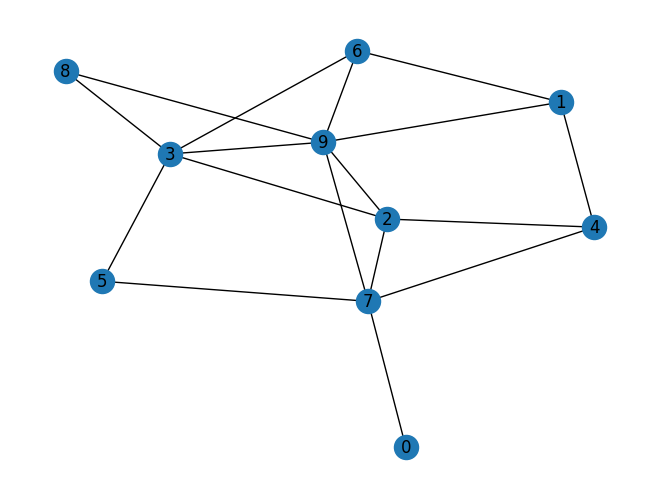

In [23]:
nx.draw(G, with_labels=True)

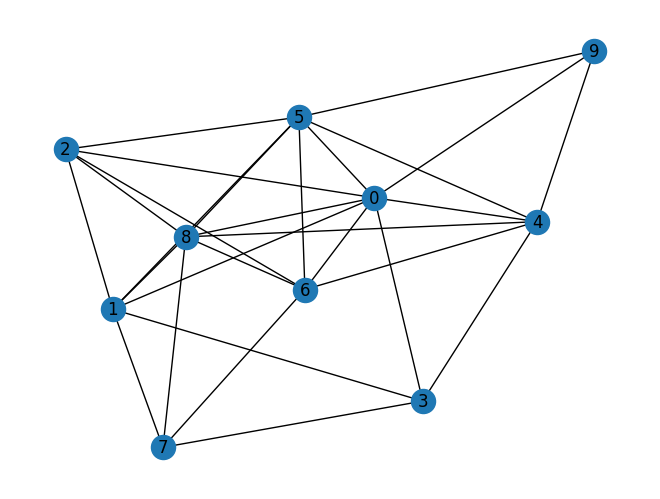

In [229]:
nx.draw(nx.complement(G), with_labels=True)

In [431]:
def pairwise_FW(edges, n, tau, max_iter = 10000, tol=1e-5, seed=None):
    # x_k = np.zeros(n)
    # x_k[3] = 1
    # alpha = np.zeros(n)
    # alpha[3] = 1
    # active_set = [3]
    rng = np.random.default_rng(seed)
    x_k = rng.random(n)
    x_k = x_k / x_k.sum()
    first_point = x_k.copy()
    active_set = []
    alpha = np.zeros(n+1)
    alpha[0] = 1

    for k in range(max_iter):
        print(f'---------------------------------Iteration {k}-----------------------------------')
        print(f'x_k {x_k}')
        # solve LMO
        s = np.zeros(n)
        grad = calc_gradient(edges, x_k, n, tau)
        grad_argmin = grad.argmin()
        s[grad_argmin] = 1
        print(f's {s}')
        # find a maximizer over the active set
        if len(active_set) == 0:
            v = first_point
            alpha_index = 0
        else:
            grad_active_set = grad[active_set]
            grad_argmax_active = grad_active_set.argmax()
            if alpha[0] > 0:
                if (first_point @ grad) > grad_active_set[grad_argmax_active]:
                    v = first_point
                    alpha_index = 0
                else:
                    v = np.zeros(n)
                    v_index = active_set[grad_argmax_active]
                    v[v_index] = 1
                    alpha_index = v_index + 1
            else:
                v = np.zeros(n)
                v_index = active_set[grad_argmax_active]
                v[v_index] = 1
                alpha_index = v_index + 1
        # choose the direction
        d_fw = s - x_k
        duality_gap = grad @ d_fw
        print(duality_gap)
        if duality_gap >= -tol:
            return x_k, k
        d = s - v
        gamma_max = alpha[alpha_index]
        print(f'gamma max {gamma_max}')
        # armijo line search
        of_old = calc_obj_function(edges, x_k, tau)
        delta = 0.9
        m = 0
        gamma = gamma_max
        x_new = x_k + gamma * d
        of_new = calc_obj_function(edges, x_new, tau)
        ineq_left_side = of_old + tol * gamma  * duality_gap
        print(of_new, ineq_left_side)
        print(f'direction {d}')
        while of_new > ineq_left_side:
            m += 1
            gamma = (delta ** m) * gamma
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            print(f'of_new {of_new}')
            if m == 20:
                raise NotImplementedError('Bad armijo')
        print(f'm {m}')
        # set the new values of alpha and the active set
        alpha[alpha_index] = alpha[alpha_index] - gamma
        alpha[grad_argmin+1] = alpha[grad_argmin+1] + gamma
        print(f'alpha {alpha}')
        x_k = x_new
        active_set = np.where(alpha[1:] > 0)[0].tolist()

    print("Maximum number of iterations reached")
    return x_k, k

In [432]:
x_k, k = pairwise_FW(complement_edges, n, 0.4, max_iter = 50)
np.round(x_k, 4), k

---------------------------------Iteration 0-----------------------------------
x_k [0.0111467  0.18790098 0.10737879 0.10274559 0.16712742 0.01078713
 0.127046   0.21119967 0.0352524  0.03941532]
s [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
-0.35947333631529044
gamma max 1.0
0.4 0.2900298267007603
direction [-0.0111467  -0.18790098 -0.10737879 -0.10274559 -0.16712742 -0.01078713
 -0.127046   -0.21119967 -0.0352524   0.96058468]
of_new 0.3467537498041074
of_new 0.277456977064639
m 2
alpha [0.271 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.729]
---------------------------------Iteration 1-----------------------------------
x_k [0.00302076 0.05092117 0.02909965 0.02784406 0.04529153 0.00292331
 0.03442947 0.05723511 0.0095534  0.73968155]
s [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
-0.4307861328146111
gamma max 0.7290000000000001
0.3243659262419357 0.2774538366337308
direction [ 0.  0.  1.  0.  0.  0.  0.  0.  0. -1.]
of_new 0.28141127932420607
of_new 0.2276608389996883
m 2
alpha [0.271    0.    

(array([0.    , 0.    , 0.3333, 0.    , 0.    , 0.    , 0.    , 0.3333,
        0.    , 0.3333]),
 18)

In [242]:
x_k = np.array([0, 0, 0.32876841, 0.33496094, 0, 0, 0, 0, 0, 0.33627066])
delta = 0.5
gamma = 0.33627065643668175
for m in range(10):
    gamma = (delta ** m) * gamma
    print(gamma)
    x_new = x_k + gamma * d
    of_new = calc_obj_function(complement_edges, x_new, 0.5)
    print(of_new)

0.33627065643668175
0.05612755751364018
0.16813532821834087
0.08313565404084272
0.04203383205458522
0.14049543021729918
0.005254229006823152
0.1632160671084151
0.000328389312926447
0.16646444387449796
1.026216602895147e-05
0.16667590312218364
1.603463442023667e-07
0.16668262112166574
1.25270581408099e-09
0.16668272692512534
4.893382086253867e-12
0.16668272775496937
9.557386887214584e-15
0.1666827277582173


In [434]:
x_k, k = pairwise_FW(existing_edges, n, 0.4, max_iter = 10000)
np.round(x_k, 4), k

---------------------------------Iteration 0-----------------------------------
x_k [0.0771206  0.13116881 0.11390738 0.0352829  0.11116856 0.10357899
 0.05910297 0.14680654 0.12269367 0.09916956]
s [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.21790389697723347
gamma max 1.0
0.4 0.21320128195227964
direction [ 0.9228794  -0.13116881 -0.11390738 -0.0352829  -0.11116856 -0.10357899
 -0.05910297 -0.14680654 -0.12269367 -0.09916956]
of_new 0.3448973068603865
of_new 0.2694259244956736
of_new 0.2116997526269516
m 3
alpha [0.468559 0.531441 0.       0.       0.       0.       0.       0.
 0.       0.       0.      ]
---------------------------------Iteration 1-----------------------------------
x_k [0.56757655 0.06146033 0.05337233 0.01653212 0.05208903 0.04853287
 0.02769323 0.06878753 0.05748922 0.04646679]
s [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
-0.3144092142614567
gamma max 0.5314410000000002
0.2177020184575686 0.21169808172747923
direction [-1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
of_new 0.1967668652478

(array([ 0.2, -0. ,  0. , -0. ,  0.2,  0.2,  0.2, -0. ,  0.2, -0. ]), 32)

In [312]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
x = x / x.sum()
x[[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]]]

array([[0.02222222, 0.04444444, 0.06666667, 0.08888889, 0.11111111,
        0.13333333],
       [0.02222222, 0.04444444, 0.06666667, 0.08888889, 0.11111111,
        0.13333333]])

In [137]:
import numpy as np
a = np.array([1, 2, 3, 4, 5])
np.where(a > 2)

(array([2, 3, 4]),)

In [381]:
a = {0}
a.add(2)
a

{0, 2}

In [482]:
def BPCG(edges, n, tau, max_iter = 10000, tol=1e-5, seed=None):
    x_k = np.zeros(n)
    x_k[0] = 1
    active_set = {0}

    for k in range(max_iter):
        print(f'---------------------------------Iteration {k}-----------------------------------')
        # solve LMO, global FW
        w = np.zeros(n)
        grad = calc_gradient(edges, x_k, n, tau)
        grad_argmin = grad.argmin()
        w[grad_argmin] = 1
        print(f'(global FW) w {w}')

        # find a maximizer and a minimizer over the active set
        active_set_list = list(active_set)
        grad_active_set = grad[active_set_list]
        grad_argmax_active = grad_active_set.argmax()
        grad_argmin_active = grad_active_set.argmin()
        a = np.zeros(n) # away step
        a_index = active_set_list[grad_argmax_active]
        a[a_index] = 1
        s = np.zeros(n) # local FW
        s_index = active_set_list[grad_argmin_active]
        s[s_index] = 1

        duality_gap = grad @ (w - x_k)
        local_gap = grad @ (a - s)
        print(f"Local vs Global: {local_gap, -duality_gap}")
        if -duality_gap <= tol:
            return x_k, k
        elif local_gap >= - duality_gap:
            print("Local FW")
            d = s - a
            gamma_max = x[a_index]

            # armijo line search
            of_old = calc_obj_function(edges, x_k, tau)
            delta = 0.5
            m = 0
            gamma = gamma_max
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            
            print(f'direction {d}')
            while of_new > of_old + tol * gamma  * duality_gap:
                print(f'armijo comparisons {of_new, of_old + tol * gamma  * duality_gap}')
                m += 1
                gamma = delta * gamma
                x_new = x_k + gamma * d
                of_new = calc_obj_function(edges, x_new, tau)
                if m == 20:
                    raise NotImplementedError('Bad armijo')

            if gamma == gamma_max:
                active_set.remove(a_index)
            else:
                pass
        else:
            print("Global FW")
            d = w - x_k
            gamma_max = 1

            # armijo line search
            of_old = calc_obj_function(edges, x_k, tau)
            delta = 0.5
            gamma = gamma_max
            x_new = x_k + gamma * d
            of_new = calc_obj_function(edges, x_new, tau)
            print(f'direction {d}')
            m = 0
            while of_new > of_old + tol * gamma  * duality_gap:
                print(f'armijo comparisons {gamma, of_new, of_old + tol * gamma  * duality_gap}')
                m += 1
                gamma = delta * gamma
                x_new = x_k + gamma * d
                of_new = calc_obj_function(edges, x_new, tau)
                if m == 20:
                    raise NotImplementedError('Bad armijo')
            if gamma == 1:
                active_set = {grad_argmin}
            else:
                active_set.add(grad_argmin)
        x_k = x_new
        print(f"Active set {active_set}")
        print(f"X {x_k}")

    print("Maximum number of iterations reached")
    return x_k, k

In [481]:
x_k, k = BPCG(complement_edges, n, 0.4, max_iter = 50)
np.round(x_k, 4), k

---------------------------------Iteration 0-----------------------------------
(global FW) w [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Local vs Global: (0.0, 0.8)
Global FW
direction [ 0.  0.  1. -1.  0.  0.  0.  0.  0.  0.]
armijo comparisons (1, 0.4, 0.399992)
Active set {2, 3}
X [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
---------------------------------Iteration 1-----------------------------------
(global FW) w [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Local vs Global: (0.0, 0.4)
Global FW
direction [ 0.   0.  -0.5 -0.5  0.   0.   0.   0.   0.   1. ]
armijo comparisons (1, 0.4, 0.199996)
Active set {9, 2, 3}
X [0.   0.   0.25 0.25 0.   0.   0.   0.   0.   0.5 ]
---------------------------------Iteration 2-----------------------------------
(global FW) w [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Local vs Global: (0.2, 0.09999999999999999)
Local FW
direction [ 0.  0.  1.  0.  0.  0.  0.  0.  0. -1.]
Active set {2, 3}
X [0.   0.   0.45 0.25 0.   0.   0.   0.   0.   0.3 ]
---------------------------------Iteration

(array([0.    , 0.    , 0.3333, 0.3333, 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.3333]),
 21)

In [483]:
x_k, k = BPCG(existing_edges, n, 0.4, max_iter = 50)
np.round(x_k, 4), k

---------------------------------Iteration 0-----------------------------------
(global FW) w [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Local vs Global: (0.0, 0.8)
Global FW
direction [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
armijo comparisons (1, 0.4, 0.399992)
Active set {0, 1}
X [0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
---------------------------------Iteration 1-----------------------------------
(global FW) w [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Local vs Global: (0.0, 0.4)
Global FW
direction [-0.5 -0.5  1.   0.   0.   0.   0.   0.   0.   0. ]
armijo comparisons (1, 0.4, 0.199996)
Active set {0, 1, 2}
X [0.25 0.25 0.5  0.   0.   0.   0.   0.   0.   0.  ]
---------------------------------Iteration 2-----------------------------------
(global FW) w [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Local vs Global: (0.2, 0.30000000000000004)
Global FW
direction [-0.25 -0.25 -0.5   0.    0.    1.    0.    0.    0.    0.  ]
armijo comparisons (1, 0.4, 0.14999700000000002)
Active set {0, 1, 2, 5}
X [0.125 0.125 0.25 

(array([0.2024, 0.2002, 0.1989, 0.    , 0.    , 0.1994, 0.    , 0.    ,
        0.1991, 0.    ]),
 49)

In [452]:
0.13333333348444296 < 0.13333333350850252

True